In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
import re

In [3]:
df_raw = pd.read_csv('../data/merged-logs_repo.csv')

In [4]:
df_code = df_raw[df_raw['is_source']==True]

Number of repositories with source code that we could find relevant results file

In [5]:
df_code.shape[0]

44

In [6]:

df_corr = df_code.corr()
df_corr = df_corr.corr()[[a for a in cor_df if 'results' in a]]
df_corr = df_corr[df_corr.index.str.match('analizo(.)*mean')]

df_corr = df_corr[~df_corr.isnull().all(axis=1)]
df_corr = df_corr.T[~df_corr.T.isnull().all(axis=1)].round(2).abs()

NameError: name 'cor_df' is not defined

### pearson correlation between code metrics and results

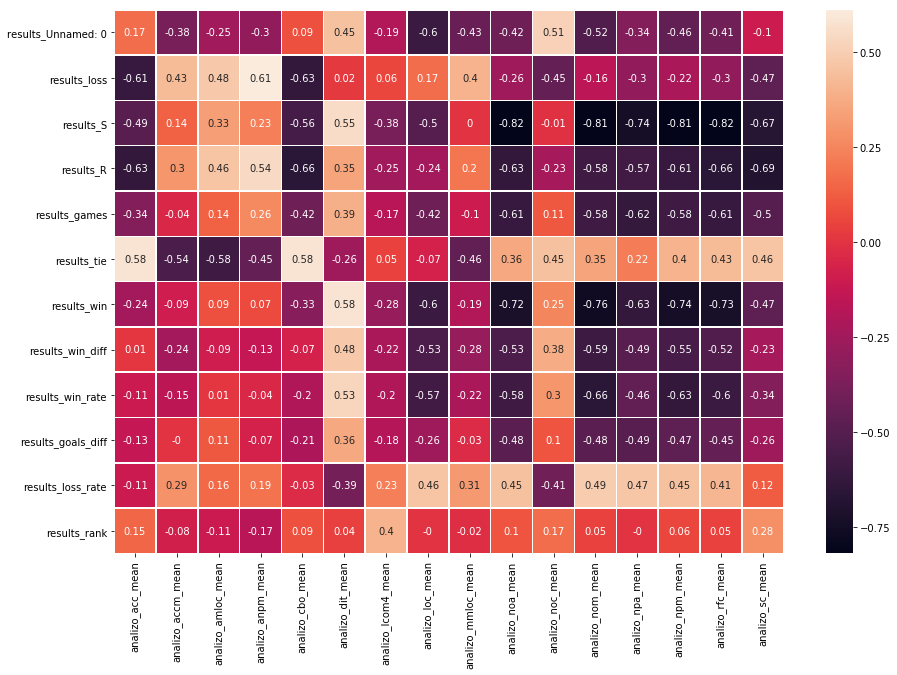

In [32]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_corr,annot=True,linewidths=.5)

The maximum values presented shows pearson correlation of all results metrics with the collected code metrics

In [36]:

df_corr = df_code.corr(method='spearman')
df_corr = df_corr.corr()[[a for a in cor_df if 'results' in a]]
df_corr = df_corr[df_corr.index.str.match('analizo(.)*mean')]

df_corr = df_corr[~df_corr.isnull().all(axis=1)]
df_corr = df_corr.T[~df_corr.T.isnull().all(axis=1)].round(2)

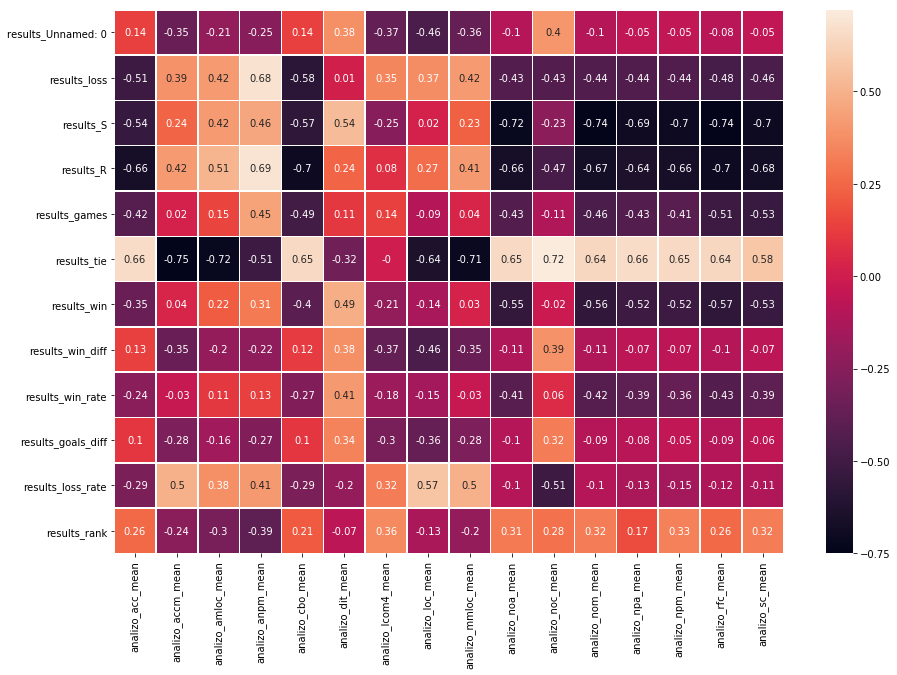

In [37]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_corr,annot=True,linewidths=.5)

In [84]:
df_code_cols = df_code[[a for a in df_code.columns if re.search('analizo(.)*(mean|max|min)',a) ]].copy()

df_code_cols.loc[:,'results_possitive_dif'] = (df_code['results_win_diff'] >0)


In [61]:
binary_df = df_raw[df_raw['is_source']!='True']

In [62]:
binary_df = binary_df[[a for a in binary_df.columns if 'analizo' not in a and 'results' not in a]]

In [64]:
import numpy as np

In [65]:
binary_df= binary_df.select_dtypes(np.number)

In [74]:
binary_df.loc[:,'is_rank'] = df_raw[df_raw['is_source']!='True']['results_rank'] >0

In [75]:
binary_df.shape[0]

410

In [76]:
binary_df_melt = binary_df.melt('is_rank',var_name='vars', value_name='val')

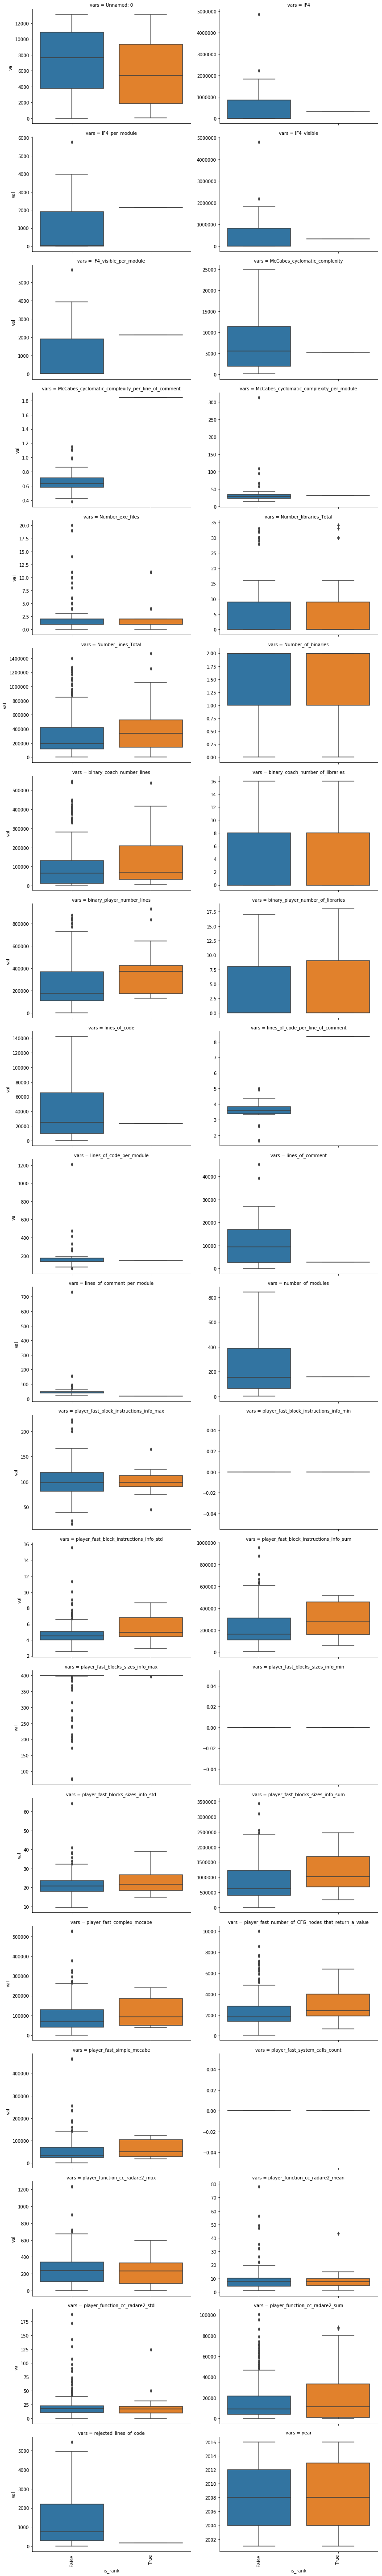

In [77]:
g = sns.catplot(x="is_rank",y = 'val',
                 col="vars",
                data=binary_df_melt, kind="box",
                height=4, aspect=1.5,col_wrap=2,sharey=False);
g.set_xticklabels(rotation=90)

In [118]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
fields = pd.read_csv('data/fields.csv')

In [119]:
fields.columns = ['name','cat']


In [120]:
binary_fields = fields[fields['cat'].isin(['basic-metric','radare','fast'])]
X = binary_df[[a for a in binary_fields['name'] if 'instructions' not in a]].copy()
Y = binary_df['is_rank']

In [121]:
X.loc[:,'year']  = df_raw['year']
X = X.drop('binary_coach_number_lines',axis=1)

In [122]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=123)
model = xgb.XGBClassifier(scale_pos_weight= float(np.sum(~y_train)) / np.sum(y_train))

In [123]:
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=8.0, seed=None,
       silent=True, subsample=1)

In [136]:
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)

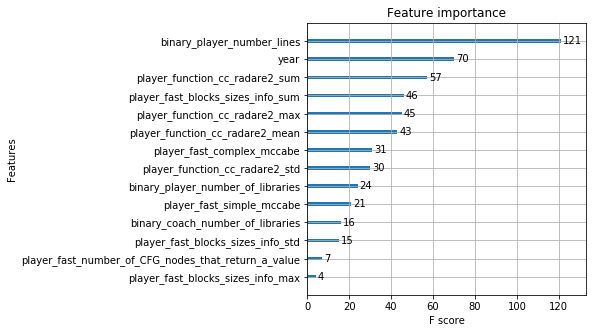

In [125]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score,auc,roc_curve

In [158]:
y_test.shape[0]

41

In [147]:
balanced_accuracy_score(y_test,y_pred)

0.597972972972973

In [148]:
balanced_accuracy_score(y_test,[False] * y_test.shape[0])

0.5

In [156]:
fpr, tpr, thresholds =roc_curve(y_test, y_pred, pos_label=1)
roc_auc= auc(fpr, tpr)

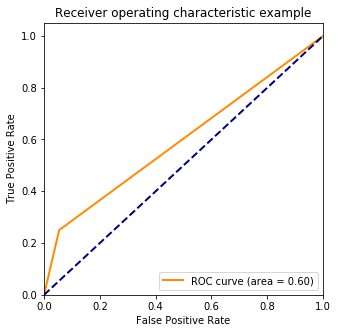

In [157]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [150]:
Y = pd.cut(df_raw['results_win_diff'],2).cat.codes.values

In [108]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)
model = xgb.XGBClassifier()

In [109]:
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
y_pred = model.predict(x_test)

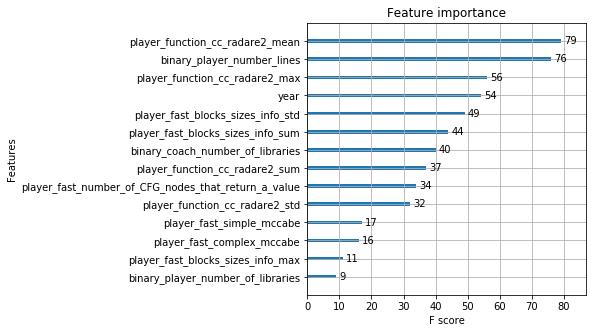

In [111]:
xgboost.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [112]:
accuracy_score(y_pred,y_test)

0.9024390243902439

In [113]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)